In [1]:
# import sys
# sys.path.append('../')

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms  import Compose, Resize, CenterCrop, ToTensor, Normalize

import numpy as np
import os
from copy import deepcopy
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import cv2

import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from umap import UMAP
import pandas as pd
import seaborn as sns

from datasets import PASTIS_Dataset, pad_collate

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_TO_PASTISR = '/data/common/STIS/PASTIS-R'
dt = PASTIS_Dataset(PATH_TO_PASTISR, norm=True, target='instance', sats=['S2','S1A','S1D'], resize=224, mono_date='20')
dl = torch.utils.data.DataLoader(dt, batch_size=128, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [3]:
(x, dates), y = dl.__iter__().__next__()

In [4]:
img = x["S2"].squeeze()[:, :3, :, :]
img.shape

torch.Size([128, 3, 224, 224])

In [5]:
img = x['S1A'].squeeze()[:, :3, :, :]
img.shape

torch.Size([128, 3, 224, 224])

In [6]:
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /home/haozhesi/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [7]:
# dinov2_vitb14

In [8]:
# for all training samples, collect patch level features
device = 2
device = torch.device(f"cuda:{device}" if torch.cuda.is_available() else "cpu")
dinov2_vitb14.to(device)
patch_level_feats = []
cls_feats = []
samples = []
feat = 'S1D'
for batch_idx, ((x, dates), y) in enumerate(tqdm(dl)):
    xs = x[feat].squeeze(1)[:, :3, :, :].to(device)

    with torch.no_grad():
        ret = dinov2_vitb14(xs, is_training=True)
    patch_level_feat = ret['x_norm_patchtokens']
    cls_feat = ret['x_norm_clstoken']
    patch_level_feats.append(patch_level_feat)
    cls_feats.append(cls_feat)
    samples.append(xs.cpu())
patch_level_feats = torch.cat(patch_level_feats, dim=0)
samples = torch.cat(samples, dim=0)
cls_feats = torch.cat(cls_feats, dim=0)

100%|██████████| 20/20 [03:36<00:00, 10.84s/it]


In [9]:
# calculate the per-sample pixel-level average values
brutal_cloud_filter = torch.mean((torch.mean(samples, dim=1) > 0.9).view(-1, 224*224).float(), dim=1) < 0.5
sum(brutal_cloud_filter)

tensor(2403)

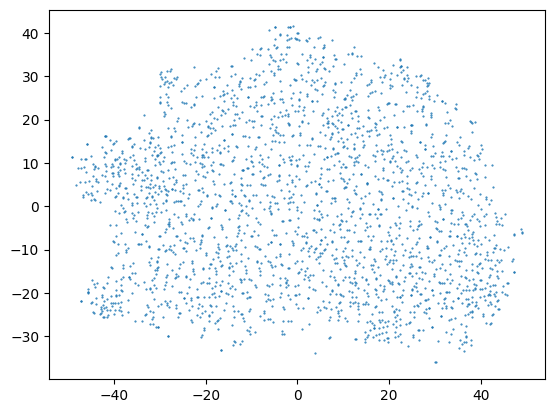

In [10]:
tsne = TSNE(n_components=2, random_state=42)
cls_feats_tsne = tsne.fit_transform(cls_feats.detach().cpu().numpy())
plt.scatter(cls_feats_tsne[:, 0], cls_feats_tsne[:, 1], marker='.', s=1)

In [13]:
patch_level_feats.shape, samples.shape
clean_patch_level_feats = patch_level_feats[brutal_cloud_filter]
# clean_samples = samples[brutal_cloud_filter]
clean_patch_level_feats = patch_level_feats
clean_samples = samples

In [14]:
# compute the PCA of the patch level features
pca = PCA(n_components=16)
pca_feat = pca.fit_transform(clean_patch_level_feats.detach().cpu().reshape(-1, 768).numpy())

In [15]:
pca_feat.shape

(622848, 16)

In [16]:
# reshape all the patch level features to 16x16
foreground_feat = pca_feat.reshape(-1, 256, 16)
# make all positive entries to 0
# foreground_feat = np.maximum(instance_pca_feat, 0)
# # if the fisrt channel is 0, then the other two channels are 0
# foreground_feat[:, :, 1:] = foreground_feat[:, :, 1:] * (foreground_feat[:, :, 0] > 0)[:, :, None]
# normalize the foreground features to [0, 1]
mx = foreground_feat.max(axis=(1, 2))
mi = foreground_feat.min(axis=(1, 2))
foreground_feat = (foreground_feat - mi[:, None, None]) / (mx - mi)[:, None, None]

In [17]:
inst_feat = foreground_feat.reshape(-1, 16, 16, 16)

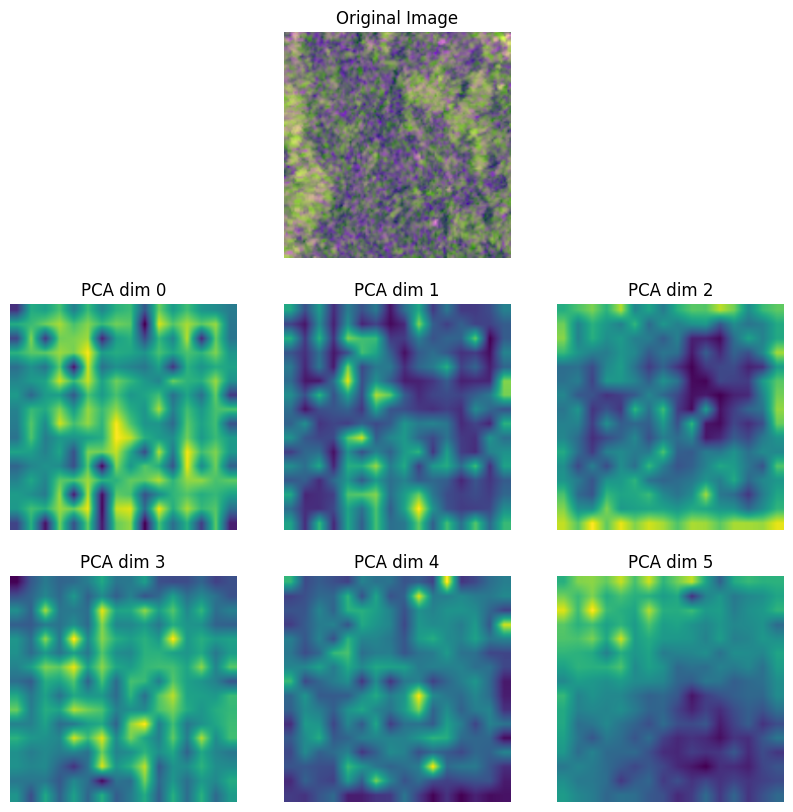

In [22]:
plt.figure(figsize=(10, 10))

idx = 4
plt.subplot(3, 3, 2)
vis_img = clean_samples[idx].permute(1, 2, 0).numpy()
vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min())
plt.axis('off')
plt.imshow(vis_img)
plt.title('Original Image')

for dim in range(6):
    vis_pca = inst_feat[idx, :, :, dim]
    # resize the patch level features to the original image size
    vis_pca = cv2.resize(vis_pca, (samples.shape[2], samples.shape[3]))
    # apply vis_pca as a mask to the original image
    vis_img_mask = vis_img * vis_pca[:, :, None]
    # visualize vis_img and vis_pca in subplot
    plt.subplot(3, 3, dim + 4)
    plt.axis('off')
    plt.imshow(vis_pca)
    plt.title('PCA dim {}'.format(dim))
plt.show()